In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from torchtext.vocab import GloVe
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect, LangDetectException
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

# Define stop words for text cleaning
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

C:\Users\Akmal Nazim\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\Akmal Nazim\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
C:\Users\Akmal Nazim\AppData\Local\Programs\Python\Python311\Lib\site-packages\

In [2]:
# Load the dataset
df = pd.read_csv("cyberbullying_tweets.csv")

In [3]:
# Describe the data
df.describe()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


(47692, 2)

In [4]:
# Checking the missing data
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [5]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [6]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [7]:
df['tweet_clean'] = [clean_tweet(tweet) for tweet in df['tweet_text']]

In [8]:
df.drop_duplicates('tweet_clean', inplace=True)

In [9]:
df.cyberbullying_type.value_counts()

cyberbullying_type
religion               7920
age                    7819
ethnicity              7415
gender                 7283
not_cyberbullying      6106
other_cyberbullying    4925
Name: count, dtype: int64

In [10]:
df.head()

,tweet_text,cyberbullying_type,tweet_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


In [11]:
# Data preprocessing
labEncoder = LabelEncoder()
labelsEncoded = labEncoder.fit_transform(df["cyberbullying_type"])

In [12]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['tweet_clean'], labelsEncoded, test_size=0.2, random_state=42)
print((train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape))

# Reset indices
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)

((33174,), (33174,), (8294,), (8294,))


In [13]:
# Define a simple tokenizer
tokenizer = get_tokenizer("basic_english")

# Build vocabulary using GloVe embeddings
glove = GloVe(name='6B', dim=100)

In [14]:
# Add a padding token to the GloVe vocabulary
glove.stoi['<pad>'] = len(glove.stoi)
pad_index = glove.stoi['<pad>']
glove_vectors = torch.cat([glove.vectors, torch.zeros(1, 100)], dim=0)

In [15]:
def text_pipeline(text):
    return [glove.stoi[token] for token in tokenizer(text) if token in glove.stoi]

In [16]:
class TextClassificationDataset(Dataset):

    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        token_ids = torch.tensor(text_pipeline(text), dtype=torch.long)
        return token_ids, torch.tensor(label, dtype=torch.long)

In [17]:
# Create datasets and dataloaders
train_dataset = TextClassificationDataset(train_texts, train_labels)
val_dataset = TextClassificationDataset(val_texts, val_labels)

In [18]:
def collate_batch(batch):
    text_list, label_list = [], []
    for (_text, _label) in batch:
        text_list.append(_text)
        label_list.append(_label)
    text_list = pad_sequence(text_list, padding_value=pad_index)
    label_list = torch.tensor(label_list, dtype=torch.long)
    return text_list.t(), label_list

In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_batch)

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(glove_vectors, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids):
        embeds = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embeds)
        pooled_output = lstm_out[:, -1, :]  # Use the output of the last LSTM cell
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [21]:
# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(embedding_dim=100, hidden_dim=128, vocab_size=len(glove.stoi), num_classes=6).to(device)

optimizer = AdamW(model.parameters(), lr=1e-3)

In [22]:
def train(model, data_loader, optimizer, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        outputs = model(input_ids)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()

In [23]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, labels = batch
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual.extend(labels.cpu().tolist())
    return accuracy_score(y_true=actual, y_pred=predictions), classification_report(y_true=actual, y_pred=predictions), actual, predictions

In [24]:
# Train model
for epoch in range(5):
    print(f"Epoch {epoch+1}/5")
    train(model, train_dataloader, optimizer, device)
    accuracy, report, actual, predictions = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/5
Validation Accuracy: 0.7898
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1550
           1       0.99      0.94      0.96      1498
           2       0.94      0.73      0.82      1453
           3       0.44      0.82      0.57      1258
           4       0.26      0.05      0.08       957
           5       0.92      0.96      0.94      1578

    accuracy                           0.79      8294
   macro avg       0.75      0.74      0.72      8294
weighted avg       0.79      0.79      0.77      8294

Epoch 2/5
Validation Accuracy: 0.7984
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1550
           1       0.97      0.97      0.97      1498
           2       0.97      0.72      0.83      1453
           3       0.52      0.19      0.28      1258
           4       0.42      0.90      0.57       957
           5       0.93      0.95      0.94      1578

 

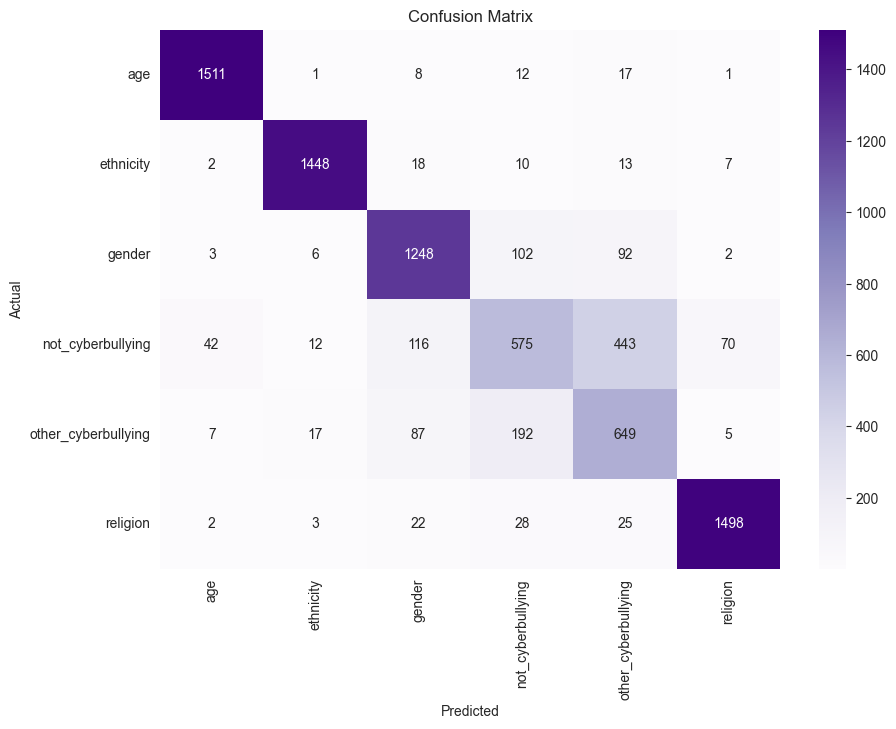

In [25]:
# Compute confusion matrix
cm = confusion_matrix(actual, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labEncoder.classes_, yticklabels=labEncoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
def predict_class(text, model, device, classes):
    model.eval()
    token_ids = torch.tensor(text_pipeline(text), dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(token_ids)
        _, preds = torch.max(outputs, dim=1)
    return classes[preds.item()]

In [27]:
# Test predictions
for _ in range(10):
    random_idx = torch.randint(len(val_texts), size=(1,)).item()
    text, label = val_texts[random_idx], labEncoder.classes_[val_labels[random_idx]]
    prediction = predict_class(text, model, device, classes=labEncoder.classes_)
    print("=============================================")
    print(f"Text:\n{text}")
    print(f"Actual: {label}\tPredicted: {prediction}")
    print("=============================================")

Text:
fix dumb as glitchy steam shit retarded nigger fuck
Actual: ethnicity	Predicted: ethnicity
Text:
open asked hard feeling good luck
Actual: not_cyberbullying	Predicted: age
Text:
daughter called bitch woman way often men know true female call bitch high school year men whole life bullshit
Actual: gender	Predicted: gender
Text:
nothing radical left embrace christianity trump pro life patriotic support christian value potus surviving year coup deserves support fire christianity today editor boycott ct change
Actual: religion	Predicted: religion
Text:
main nigger dumb fuck though
Actual: ethnicity	Predicted: ethnicity
Text:
know anything else white history moment got school shit black history teach shit past surface level
Actual: ethnicity	Predicted: ethnicity
Text:
islam forcing people muslim even perverted imam know
Actual: religion	Predicted: religion
Text:
meangive cop fucking pepsi get shot racism terrible
Actual: ethnicity	Predicted: ethnicity
Text:
yeah got cron kick must kick